# In this notebook, we have discussed implementing the Multiclass text classification with [Distilbert Model](https://arxiv.org/pdf/1910.01108.pdf) using [ktrain library](https://pypi.org/project/ktrain/)

Let's discuss about all these terms in detail:
1.   Multiclass text classification: It is the problem of classifying text 
instances (documents/query/tickets) into one of three or more classes.
<br> <br> Example: Classifying queries raised by bank customers into one of the relevant 
categories like loan related, credit card related, debit card related etc. 
<br><br> Note: Text classification is an example of supervised machine learning.


2. Distilbert model: It is deep learning based general purpose language model. It is pretrained on large corpus on text data. 

3.   Ktrain is a lightweight wrapper for the deep learning library TensorFlow Keras (and other libraries) to help build, train, and deploy neural networks and other machine learning models.


# Import required libraries

In [2]:
import ktrain 
from ktrain import text
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import dotenv
import os
from pathlib import Path

# In order to get reproducible results, set random seed. 

In [3]:
def reset_random_seeds(seed=2):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
reset_random_seeds() 

Follow the link to enable GPU 
https://learnopencv.com/how-to-use-opencv-dnn-module-with-nvidia-gpu-on-windows/

# If GPU is available then below code will enable GPU to be used by model training, otherwise model will be trained on CPU. 

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Read IT-tickets data

In [30]:
dotenv.load_dotenv() 
# #this brings values into the environment matching the key in quotes
main_dir = Path(os.getenv('train_main_dir'))
train_str = "train_data_derived.csv"
test_str = "test_data_derived.csv"

data_dir = main_dir /"input_data"/"training_data"/"derived_dataframe_data"  
save_dir = main_dir /"output"

In [13]:
train_data = pd.read_csv(data_dir/train_str,index_col=0)
test_data = pd.read_csv(data_dir/test_str,index_col =0)

In [14]:
train_data = train_data.drop("Ticket_ID",axis= 1)

In order to pass equal amount of rows related to each tag to train and validation set, shuffle the data.

In [16]:
train_data = train_data.sample(frac = 1).reset_index()
train_data.drop(["index"],inplace=True,axis=1)

Print few rows of the train data. <br> In train_data, first column has text data as ticket description and remaining columns are having class values as 0 or 1. 

In [17]:
train_data.head()

,Body,Application_Administration,Corporate_Provisioning,Genesys_Support_Team,IT_Asset_Management,Service_Desk_-_Albany,Service_Desk_-_Enterprise_Tier_-_1,Service_Desk_-_Enterprise_Tier_-_2,SharePoint
0,Departure Notification Departure Notification\...,1,0,0,0,0,0,0,0
1,Replacement Laptop I need my laptop replaced. ...,0,0,0,1,0,0,0,0
2,Return Maximus equipment. - -(Submitted by Rya...,0,0,0,1,0,0,0,0
3,Siebel AMC server correction Please update the...,1,0,0,0,0,0,0,0
4,AidVantage thin client and peripherals - Amide...,0,0,0,1,0,0,0,0


Below code shows the class distribution of train_data. <br>
There are total 8 classes/categories of tickets or we can say each ticket can belong any one of 8 types of services. 

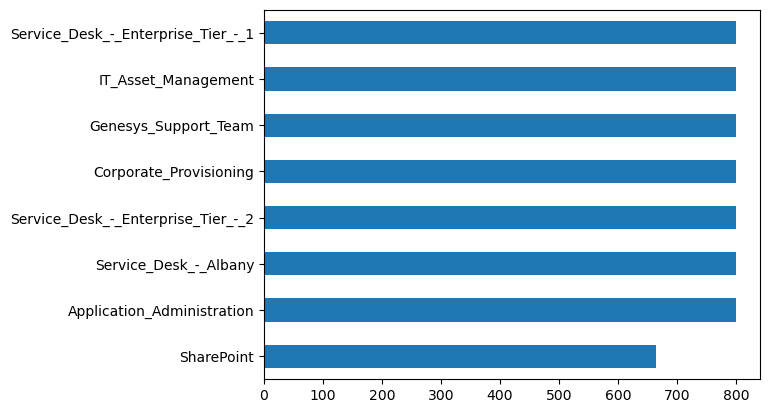

In [18]:
LABEL_COLUMNS = train_data.columns.tolist()[1:]
train_data[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

# Split data into Train, Validation and Test

In [33]:
# Consider last 1500 rows from train set, as validation set
train_df, val_df, test_df = train_data[:-1500],train_data[-1500:], test_data
x_train,y_train = train_df.iloc[:,0].values, train_df.iloc[:,1:].values
x_val,y_val = val_df.iloc[:,0].values, val_df.iloc[:,1:].values
x_test,y_test = test_df.iloc[:,1].values, test_df.iloc[:,2:].values

In [20]:
class_names = train_data.columns[1:].tolist()

In [34]:
class_names

['Application_Administration',
 'Corporate_Provisioning',
 'Genesys_Support_Team',
 'IT_Asset_Management',
 'Service_Desk_-_Albany',
 'Service_Desk_-_Enterprise_Tier_-_1',
 'Service_Desk_-_Enterprise_Tier_-_2',
 'SharePoint']

# Convert data into required form by Ktrain library and fine-tune distilbert model.


Loads and preprocess text data from array by text module of ktrain.

In [35]:
trn, val, preproc = text.texts_from_array(x_train=x_train, y_train=y_train,
                                          x_test=x_val, y_test=y_val,
                                          class_names=class_names,
                                          preprocess_mode='distilbert',
                                          maxlen=512)

preprocessing train...
language: en
train sequence lengths:
	mean : 41
	95percentile : 109
	99percentile : 240


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 41
	95percentile : 105
	99percentile : 259


task: text classification


Download pre-trained distilbert model for transfer learning.

In [22]:
model = text.text_classifier('distilbert', train_data=trn, preproc=preproc)

Is Multi-Label? False
maxlen is 512
done.


In [23]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=2)

Print the summary of the model.

In [24]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  6152      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,959,624
Trainable params: 66,959,624
Non-trainable params: 0
_________________________________________________________________


Train the model for 8 epochs, as after 7 epochs validation loss started increasing.  

Note: we can experiment increasing or decreasing the number of epochs in order to see the impact on performance.

In [25]:
learner.fit_onecycle(3e-5, 8) # (learning rate,  epochs =8)



begin training using onecycle policy with max lr of 3e-05...
Epoch 1/8
2381/2381 [==============================] - 5330s 2s/step - loss: 1.2041 - accuracy: 0.6217 - val_loss: 0.6235 - val_accuracy: 0.7807
Epoch 2/8
2381/2381 [==============================] - 5279s 2s/step - loss: 0.5209 - accuracy: 0.8217 - val_loss: 0.5244 - val_accuracy: 0.8307
Epoch 3/8
2381/2381 [==============================] - 5246s 2s/step - loss: 0.3783 - accuracy: 0.8712 - val_loss: 0.5191 - val_accuracy: 0.8287
Epoch 4/8
2381/2381 [==============================] - 5227s 2s/step - loss: 0.3198 - accuracy: 0.8918 - val_loss: 0.5103 - val_accuracy: 0.8380
Epoch 5/8
2381/2381 [==============================] - 5229s 2s/step - loss: 0.2601 - accuracy: 0.9164 - val_loss: 0.5147 - val_accuracy: 0.8380
Epoch 6/8
2381/2381 [==============================] - 5238s 2s/step - loss: 0.1691 - accuracy: 0.9496 - val_loss: 0.6003 - val_accuracy: 0.8320
Epoch 7/8
2381/2381 [==============================] - 5220s 2s/ste

# Test model on test data and calculate evaluation metrics.

In [26]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [36]:
pred_result = predictor.predict(x_test)

49/49 [==============================] - 426s 9s/step


In [39]:
# converting test prediction in 1-D array and assign label from 0 to len(class_names)-1
pred = np.zeros((len(pred_result)))
for i in range(len(pred_result)):
    pred[i] = class_names.index(pred_result[i])
test_pred = pred

In [40]:
test_pred

array([0., 0., 0., ..., 7., 7., 7.])

In [41]:
# converting test actual in 1-D array from n-d array
test_actual =  np.zeros((len(y_test)))
for i in range(len(y_test)):
  test_actual[i] = int(np.where(y_test[i]==1)[0][0])

# Generally multi class classification model is evaluated on following metrics:

1. Accuracy :<br>
The base metric used for model evaluation is often Accuracy, describing the number of correct predictions over all predictions.

2. Precision:<br>
Precision is a measure of how many of the positive predictions made are correct. 

3. Recall:<br>
Recall is a measure of how many of the positive cases the classifier correctly predicted, over all the positive cases in the data.

4. F1-Score:<br>
F1-Score is a measure combining both precision and recall. It is generally described as the harmonic mean of the two. Harmonic mean is just another way to calculate an “average” of values, generally described as more suitable for ratios (such as precision and recall) than the traditional arithmetic mean.

Accuracy is not a good measure in case if data having unbalanced classes. <br><br>
Here we are interested in getting high value of accuracy and f1-score both as f1-score can summarise both precision and recall together.  <br><br>
Below code prints all the required metrics.

In [42]:
print(classification_report(
  test_actual, 
  test_pred, 
  target_names=class_names, 
  zero_division=0
))

                                    precision    recall  f1-score   support

        Application_Administration       0.96      0.94      0.95       200
            Corporate_Provisioning       0.88      0.85      0.87       200
              Genesys_Support_Team       0.92      0.97      0.94       200
               IT_Asset_Management       0.96      0.85      0.90       200
             Service_Desk_-_Albany       0.95      0.92      0.93       200
Service_Desk_-_Enterprise_Tier_-_1       0.64      0.82      0.72       200
Service_Desk_-_Enterprise_Tier_-_2       0.59      0.51      0.55       200
                        SharePoint       0.95      0.92      0.94       166

                          accuracy                           0.85      1566
                         macro avg       0.85      0.85      0.85      1566
                      weighted avg       0.85      0.85      0.85      1566



# Confusion Matrix

The number of correct and incorrect predictions are summarized with count values and broken down by each class. <br><br>

The confusion matrix shows the ways in which your classification model
is confused when it makes predictions.
<br><br>
Below code prints the confusion matrix for classification model.

In [43]:
confusion_matrix(test_actual, test_pred)
c_m = pd.DataFrame(confusion_matrix(test_actual, test_pred), columns= class_names)
c_m.index=class_names
c_m

,Application_Administration,Corporate_Provisioning,Genesys_Support_Team,IT_Asset_Management,Service_Desk_-_Albany,Service_Desk_-_Enterprise_Tier_-_1,Service_Desk_-_Enterprise_Tier_-_2,SharePoint
Application_Administration,189,1,0,2,3,0,4,1
Corporate_Provisioning,0,170,1,1,0,10,18,0
Genesys_Support_Team,1,0,195,0,0,1,2,1
IT_Asset_Management,0,8,4,171,0,5,12,0
Service_Desk_-_Albany,3,0,0,0,183,10,4,0
Service_Desk_-_Enterprise_Tier_-_1,2,6,2,2,0,164,23,1
Service_Desk_-_Enterprise_Tier_-_2,1,6,9,3,7,67,102,5
SharePoint,0,2,2,0,0,1,8,153


# let's predict the tags for few of the example tickets.

In [ ]:
ticket_description_1 = '{\n  "Customer Display Name": "Sindy E Pacheco",\n  "Customer Title": "Supervisor - Call Center",\n  "Incident Type": "Incident",\n  "Incident ID": "3495927",\n  "Priority": "3",\n  "Customer Escalation": "Normal",\n  "Short Description": "NYSOH-30 Remote-Oracle password reset",\n  "Created By": "Alex Simpson",\n  "Description": "Hello-\\\\n\xa0\\\\nPlease assist in resetting password for my standalone OKM\\\\n\xa0\\\\nEIN: 51855\\\\n\xa0\\\\nThank you,",\n  "Journal Notes": "Journal Note Added by Ravindra Kambala at 7/14/2022 2:47 AM\\\\nAccount has been unlocked and password updated and shared via mail",\n  "Service": "Application Support and Development",\n  "Category": "Cloud Application Services - Submit Incident",\n  "Subcategory": "OKM - Oracle Knowledge Modules - Submit Incident"\n}\n'
#This is 1st example from test set.

op = predictor.predict([ticket_description_1])

actual_tags = test_data.iloc[0,1:][(test_data.iloc[0,1:]==1)].index
print("\nActual tag for ticket_description_1 is: ",list(actual_tags)[0])


print("\nPredicted tag for ticket_description_1 is :",op[0])

In [ ]:
ticket_description_2 ='{\n  "Customer Display Name": "External Customer",\n  "Customer Title": "",\n  "Incident Type": "Service Request",\n  "Incident ID": "3566289",\n  "Priority": "5",\n  "Customer Escalation": "Normal",\n  "Short Description": "Departure Notification",\n  "Created By": "Kevin Prosser",\n  "Description": "Departure Notification\\\\n--------------------------------------------------\\\\nEmployee: \xa0Yashira Plaza Ramos\\\\nEmployee ID: \xa0467901\\\\nEmail Address: \xa0YashiraPlazaRamos@maximus.com\\\\nMAX Status: \xa0No Start\\\\n--------------------------------------------------\\\\nProject: \xa0NYSOH\\\\nLocation: \xa0New York\\\\nTitle: \xa0CSS III\\\\nManager: \xa0Darwin Pacheco (31493)\\\\nSupervisor: \xa0Abubakar Mazhar (61008)\\\\nStart Date: \xa008/15/2022\\\\nTerm Date: \xa008/15/2022\\\\nMAX Type: \xa0Perm",\n  "Journal Notes": "",\n  "Service": "Access and Account Management",\n  "Category": "Employee Support",\n  "Subcategory": "NYSOH Terminate (Separation) - Employee/Contractor"\n}\n'
#This is 101 example from test set.

op = predictor.predict([ticket_description_2])

actual_tags = test_data.iloc[100,1:][(test_data.iloc[100,1:]==1)].index
print("\nActual tag for ticket_description_2 is: ",list(actual_tags)[0])


print("\nPredicted tag for ticket_description_2 is :",op[0])

Save trained model.

In [31]:
predictor.save(save_dir/"model_distilbert")